## The Covid Period

We define the covid period as being between 1/1/2020 and 31/12/2022. We have made this inference through the CDC's website - whilst the outbreak was first documented as novel on January 7th, COVID screening and spread began mid-January. By January 23rd, Wuhan, China, a city of 11 million is placed under lockdown. 

December 2020 saw the roll out of the rapidly formulated and released COVID vaccine in the US, with 1 million vaccines being administered in 10 days. 

By mid-2022 the US population is >50% vaccinated across all age groups over 10. We will consider the end of 2022 as the end of the COVID period. Why? 

Whilst the memory of COVID is engrained, does the effects of it still take its toll on the markets? Was there a shift? Will we revert? Let's see. 



In [4]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import grangercausalitytests
from vortexasdk import CargoTimeSeries, Products, Geographies

warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams.update({'font.size': 14})
pd.options.display.max_columns = None

- We begin this analysis by taking a look at the crude oil floating storage data and its relationship to crude oil prices from January 2020 to December 2022. This will enable us to analyse trends throughout the COVID pandemic. 
- The pandemic was characterised by large swings so we expect to see some volatility. Most notably during April 2020 where crude oil prices went negative for the first time in history. 
- We use this 3 year period to analyse how the pandemic affected crude oil. 

In [5]:
#Defining date range for historical analysis
START_DATE = datetime(2020, 1, 1)
END_DATE = datetime(2022, 12, 31)
DATE_RANGE = pd.date_range(START_DATE, END_DATE)
#['2020-04-20']
CRUDE_NEGATIVE_PRICES_DATE = datetime(2020, 4, 20)

#Floating storage unit (t = metric tonnes, b = barrels)
UNIT = 't'

In order to conduct our statistical analysis, we have removed all values for 20th April 2020, where crude oil prices dipped below 0. This is to purge our data of outliers. 

In [6]:
def fetch_global_crude_floating_storage_timeseries(start_date, end_date, unit='t'):
    
    # Find Crude/Condensates ID, ensuring its uniqueness
    crude_and_condensates = [p.id for p in Products().search('crude').to_list() if p.name=='Crude/Condensates']
    assert len(crude_and_condensates) == 1
    
    # make Vortexa API query
    # NB: disable_geographic_exclusion_rules is set to True to include intra-movements
    df_fs = CargoTimeSeries().search(timeseries_frequency='day',
                                     timeseries_unit=unit,
                                     intra_movements='all',
                                     filter_products=crude_and_condensates,
                                     filter_activity="storing_state",
                                     filter_time_min=start_date,
                                     filter_time_max=end_date).to_df()

    # rename columns
    df_fs = df_fs.rename(columns={'key': 'date',
                                  'value': unit,
                                  'count': 'number_of_cargo_movements'})
    
    # remove time zone from timestamp
    df_fs['date'] = pd.to_datetime(df_fs['date']).dt.tz_localize(None)

    #define the date crude oil prices went negative
    negative_price_date = pd.to_datetime("2020-04-20")

    # Remove the negative price date from floating storage dataset
    df_fs = df_fs[df_fs['date'] != negative_price_date]
    
    return df_fs

- Fetching Floating Storage data from the Cargo Timeseries endpoint 

In [7]:
df_fs = fetch_global_crude_floating_storage_timeseries(START_DATE, END_DATE, UNIT)
df_fs

,date,number_of_cargo_movements,t
0,2020-01-01,145,9102904
1,2020-01-02,135,8524530
2,2020-01-03,137,7837530
3,2020-01-04,133,7974007
4,2020-01-05,139,8658888
...,...,...,...
1091,2022-12-27,171,13319872
1092,2022-12-28,181,13520692
1093,2022-12-29,176,14084738
1094,2022-12-30,172,14254032


- The above dataframe contains the dates spanning January 2020 to December 2022, approx a 3 year period. 

Text(0, 0.5, 'Floating Storage (t)')

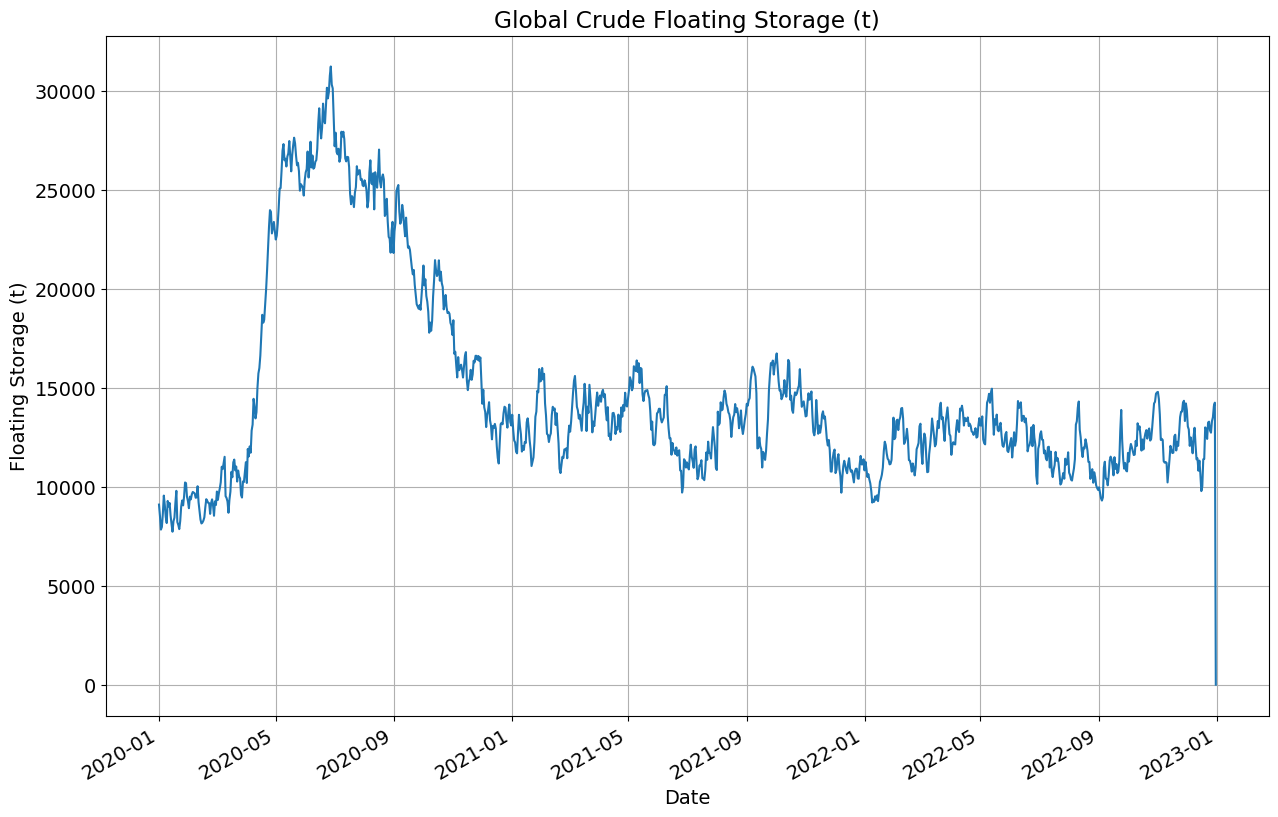

In [8]:
floating_storage = df_fs.set_index('date')[UNIT] / 1000
floating_storage.plot(title='Global Crude Floating Storage (t)', grid=True)
plt.xlabel('Date')
plt.ylabel('Floating Storage (t)')

The above is a Pandas Series to hold the floating storage quantity in kt and we use this series to plot the data. 

The graph above shows that global floating storage levels experienced massive fluctuations throughout 2020, gradually rising from April (where crude went negative) and reaching its peak in July 2020, at 30,000 tonnes.

From this point it decreased and found its range in January 2021, nearly 6 months after its peak. From this point it fluctuated between 10,000 and 15,000 tonnes between 2021 and December 2022. 

Below: EIA crude oil prices
The US Energy Information Administration (EIA) reports daily spot prices of crude oil and other products on their website. This data is publicly available and we download the Excel file directly into a Pandas DataFrame below. (NB: although the series has daily resolution, the Excel file is updated on a weekly basis. For details see the information in the Regular Weekly Releases box.) ffill is used to fill gaps in the price data, so we can compare the latest price against floating storage.
We have removed dates where crude oil prices dipped below 0 in order to strip our data set of outliers. 

In [9]:
spot_prices = pd.read_excel('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_D.xls', sheet_name='Data 1', skiprows=[0,1])
spot_prices = spot_prices.set_index('Date').fillna(method='ffill').reindex(DATE_RANGE, method='ffill')
negative_price_date = spot_prices[spot_prices.iloc[:, 0] < 0].index
print(negative_price_date)
spot_prices = spot_prices.drop(negative_price_date)
spot_prices

DatetimeIndex(['2020-04-20'], dtype='datetime64[ns]', freq='D')


,"Cushing, OK WTI Spot Price FOB (Dollars per Barrel)",Europe Brent Spot Price FOB (Dollars per Barrel)
2020-01-01,61.14,67.77
2020-01-02,61.17,67.05
2020-01-03,63.00,69.08
2020-01-04,63.00,69.08
2020-01-05,63.00,69.08
...,...,...
2022-12-27,79.45,82.45
2022-12-28,78.89,81.70
2022-12-29,78.43,80.96
2022-12-30,80.16,82.82


We open the sheet containing the crude oil spot prices (sheet Data 1) in the DataFrame and see that it contains two series: Cushing, OK WTI Spot Price and Europe Brent Spot Price. WTI (West Texas Intermediate) is the name of a crude oil grade produced in the US, and Brent is a crude grade produced in the North Sea. Both prices are used as international benchmark in oil transactions. This data is plotted below.

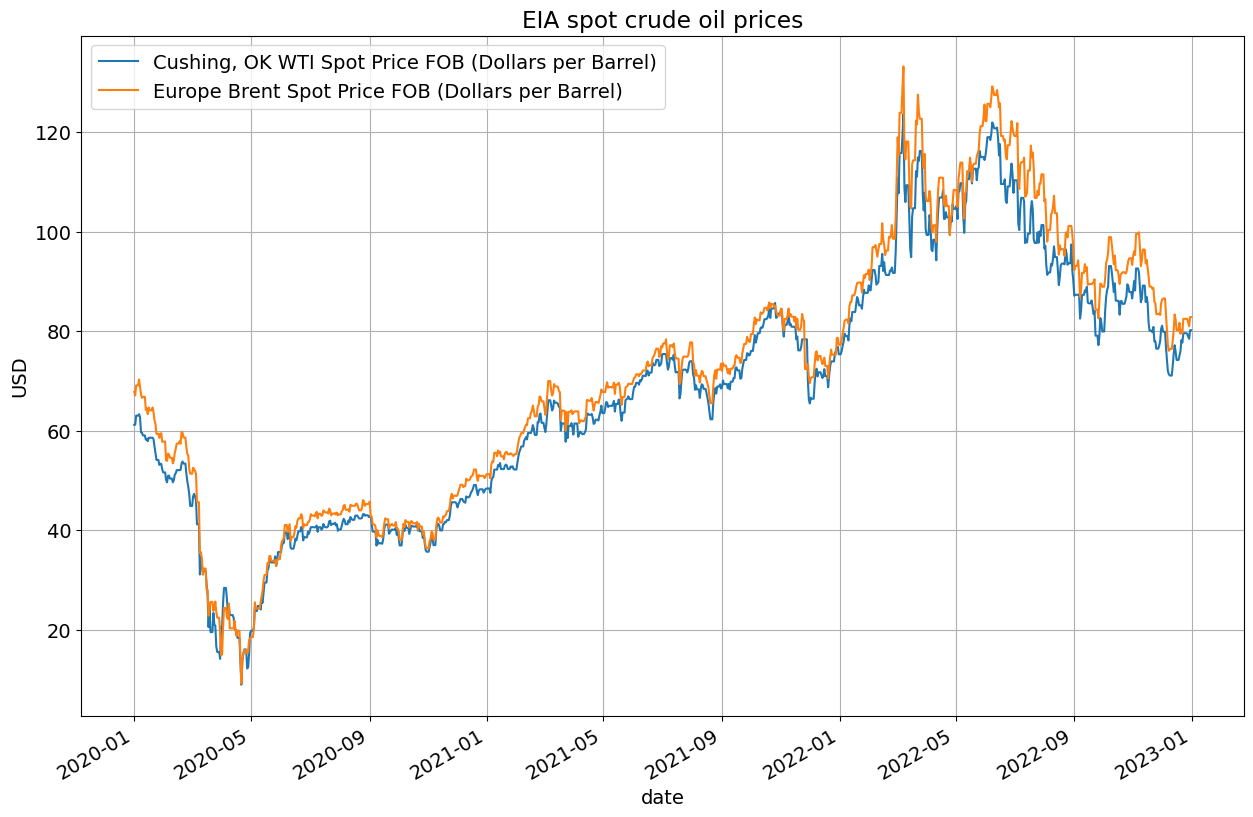

In [10]:
spot_prices.plot(title='EIA spot crude oil prices', grid=True)
plt.xlabel('date')
plt.ylabel('USD');
#removed dates where crude oil prices are negative


Crude oil prices began 2020 in turmoil, reflecting the shock of the COVID pandemic. Whilst they did go sub-zero in April, their lowest daily close was approximately $7/barrel. This is in stark contrast to their previous low of ~$15 between 2017 and 2019. 

From this point onwards prices increased significantly and consistently, reaching a peak in March 2022 at around $125/barrel. 

We proceed the analysis with Cushing, OK WTI Spot Price, which is kept as a Pandas Series below. We choose WTI because EIA provides both spot and future prices for WTI, but not for Brent.

- The line below extracts the first column of information from the spot prices data frame, excluding Brent prices. 

In [11]:
spot_prices = spot_prices.iloc[:, 0]

In [12]:
future_prices = pd.read_excel('https://www.eia.gov/dnav/pet/xls/PET_PRI_FUT_S1_D.xls', sheet_name='Data 1', skiprows=[0,1])
future_prices = future_prices.set_index('Date').fillna(method='ffill').reindex(DATE_RANGE, method='ffill')
future_prices = future_prices.drop(negative_price_date)
future_prices
#removed date (20/04/2020) where spot crude oil prices were negative

,"Cushing, OK Crude Oil Future Contract 1 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 2 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 3 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 4 (Dollars per Barrel)"
2020-01-01,61.06,60.77,60.41,59.97
2020-01-02,61.18,60.95,60.64,60.24
2020-01-03,63.05,62.82,62.48,62.02
2020-01-04,63.05,62.82,62.48,62.02
2020-01-05,63.05,62.82,62.48,62.02
...,...,...,...,...
2022-12-27,79.53,79.64,79.68,79.57
2022-12-28,78.96,79.08,79.13,79.05
2022-12-29,78.40,78.50,78.54,78.46
2022-12-30,80.26,80.45,80.53,80.45


The Data 1 sheet in the Excel file contains the prices of four different crude oil future contracts (Contract 1-4). "Contract 1" sets the physical delivery of crude oil in the month following the expiry date of the contract, "Contract 2" sets the delivery 2 months ahead, and so on until "Contract 4" (for details please refer here). A plot of the four future contract prices is shown below.

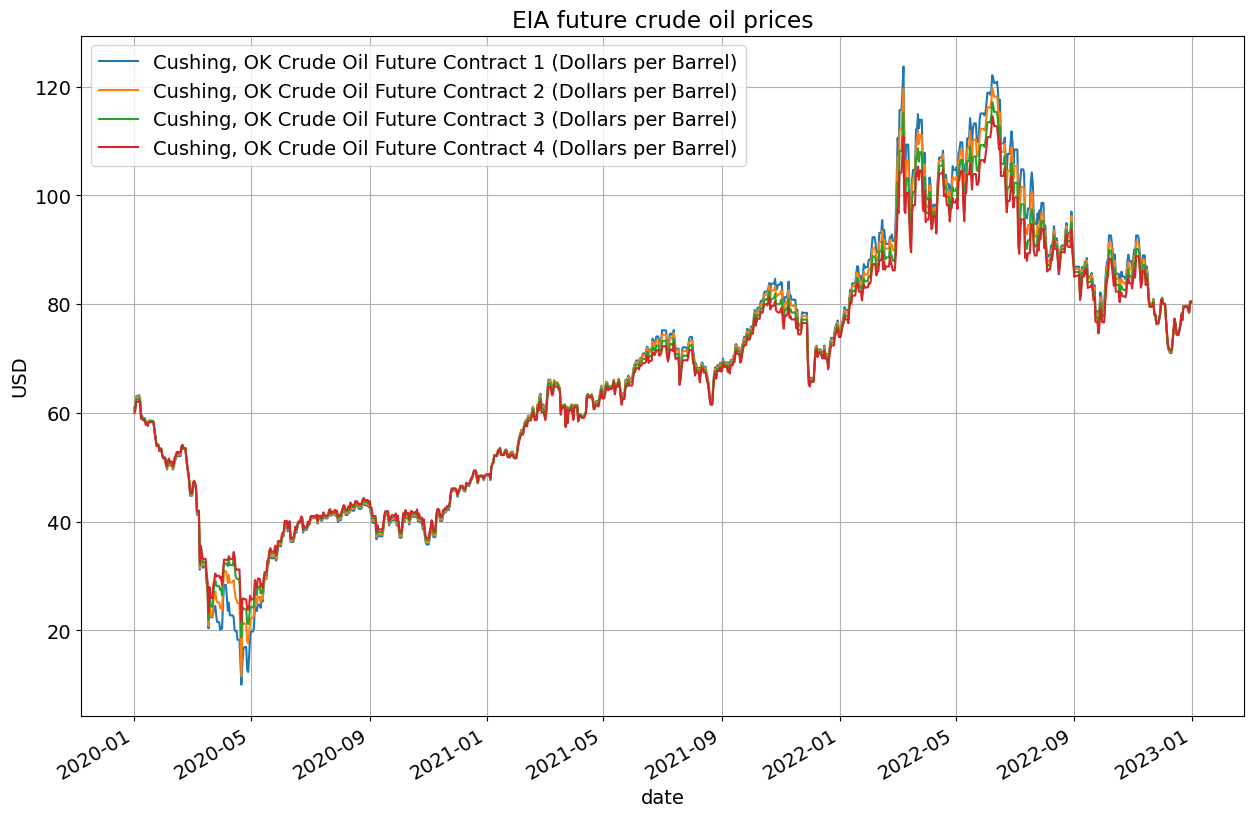

In [13]:
future_prices.plot(title='EIA future crude oil prices', grid=True)
plt.xlabel('date')
plt.ylabel('USD');

Next we calculate the difference between the future prices and the spot price, also known as calendar spread.

In [14]:
calendar_spread = future_prices - pd.concat([spot_prices] * 4, axis=1).values
# print(future_prices.shape)
calendar_spread

,"Cushing, OK Crude Oil Future Contract 1 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 2 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 3 (Dollars per Barrel)","Cushing, OK Crude Oil Future Contract 4 (Dollars per Barrel)"
2020-01-01,-0.08,-0.37,-0.73,-1.17
2020-01-02,0.01,-0.22,-0.53,-0.93
2020-01-03,0.05,-0.18,-0.52,-0.98
2020-01-04,0.05,-0.18,-0.52,-0.98
2020-01-05,0.05,-0.18,-0.52,-0.98
...,...,...,...,...
2022-12-27,0.08,0.19,0.23,0.12
2022-12-28,0.07,0.19,0.24,0.16
2022-12-29,-0.03,0.07,0.11,0.03
2022-12-30,0.10,0.29,0.37,0.29


Plotting the calendar spreads makes it easy to visualise the periods in which the crude oil market was in contango (spread > 0) and in backwardation (spread < 0).

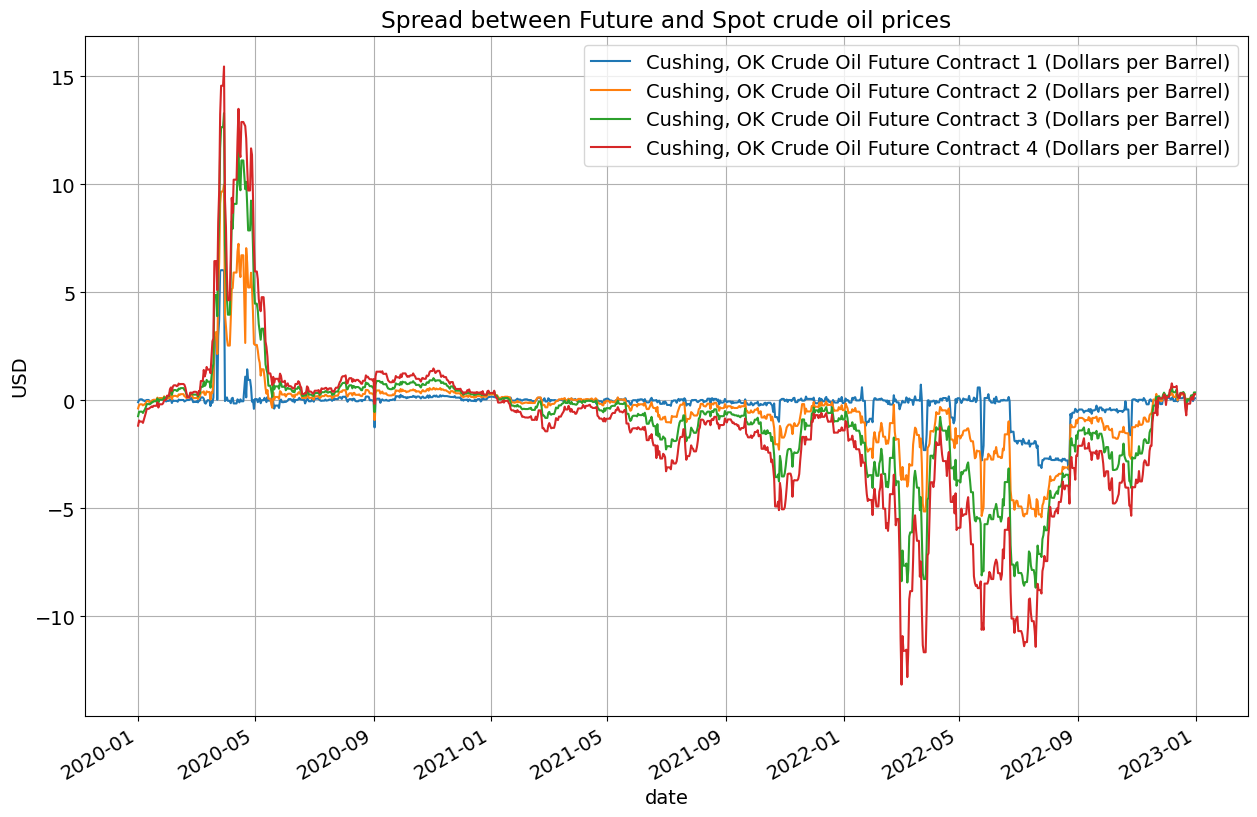

In [15]:
calendar_spread.plot(title='Spread between Future and Spot crude oil prices', grid=True)
plt.xlabel('date')
plt.ylabel('USD');

We will continue the analysis with "Cushing, OK Crude Oil Future Contract 4" future prices and the corresponding calendar spread, both as Pandas Series.

In [16]:
future_prices = future_prices.iloc[:, 3]
calendar_spread = calendar_spread.iloc[:, 3]

## Cross Correlation Analysis

In [17]:
# Maximum lag in days used for cross-correlation and Granger causality analysis
MAXLAG = 100

We start investigating the relationship between floating storage and prices by doing a simple cross-correlation analysis. For this, we use the pandas.Series.corr function to compute the Pearson correlation coefficient between two time series as we slide one of them in time using the shift function.

In [18]:
def crosscorr(series_x, series_y, lags):
    return pd.Series([series_y.corr(series_x.shift(lag)) for lag in lags], index=lags)

To illustrate how this function works, let's look at the first few lags when we cross-correlated calendar_spread and floating_storage:

In [19]:
crosscorr(calendar_spread, floating_storage, lags=[0, 1])

0    0.343204
1    0.351052
dtype: float64

All values are Pearson correlation coefficients between the two input variables. The index values correspond to the number of days the first variable is shifted "down" relative to the second one, so past values of the first variable are correlated against the present values of the second variable. In the above example, at index 1 "today's" floating storage is correlated with "yesterday's" calendar spread, or equivalently the calendar spread is correlated against floating storage 1 day in the future.
Example?

To help visualise the cross-correlation between the different variables, we define the following function:

In [20]:
def plot_crosscorr(series_x, series_y, maxlag, label_x, label_y):
    lags = np.arange(0, maxlag+1)

    plt.subplot(211)
    xcorr_x_y = crosscorr(series_x, series_y, lags)
    xcorr_x_y.plot(title=f'{label_x} -> {label_y}', grid=True)
    plt.ylabel('correlation coeff.')

    plt.subplot(212)
    xcorr_y_x = crosscorr(series_y, series_x, lags)
    xcorr_y_x.plot(title=f'{label_y} -> {label_x}', grid=True)
    plt.xlabel('lag [days]')
    plt.ylabel('correlation coeff.')

plot_crosscorr splits the cross-correlation results in two: the top plot has the correlation values between series_x and future values of series_y, and the bottom plot the correlation between series_y and future values of series_x. Plotting the cross-correlation between calendar spread and floating storage we obtain:

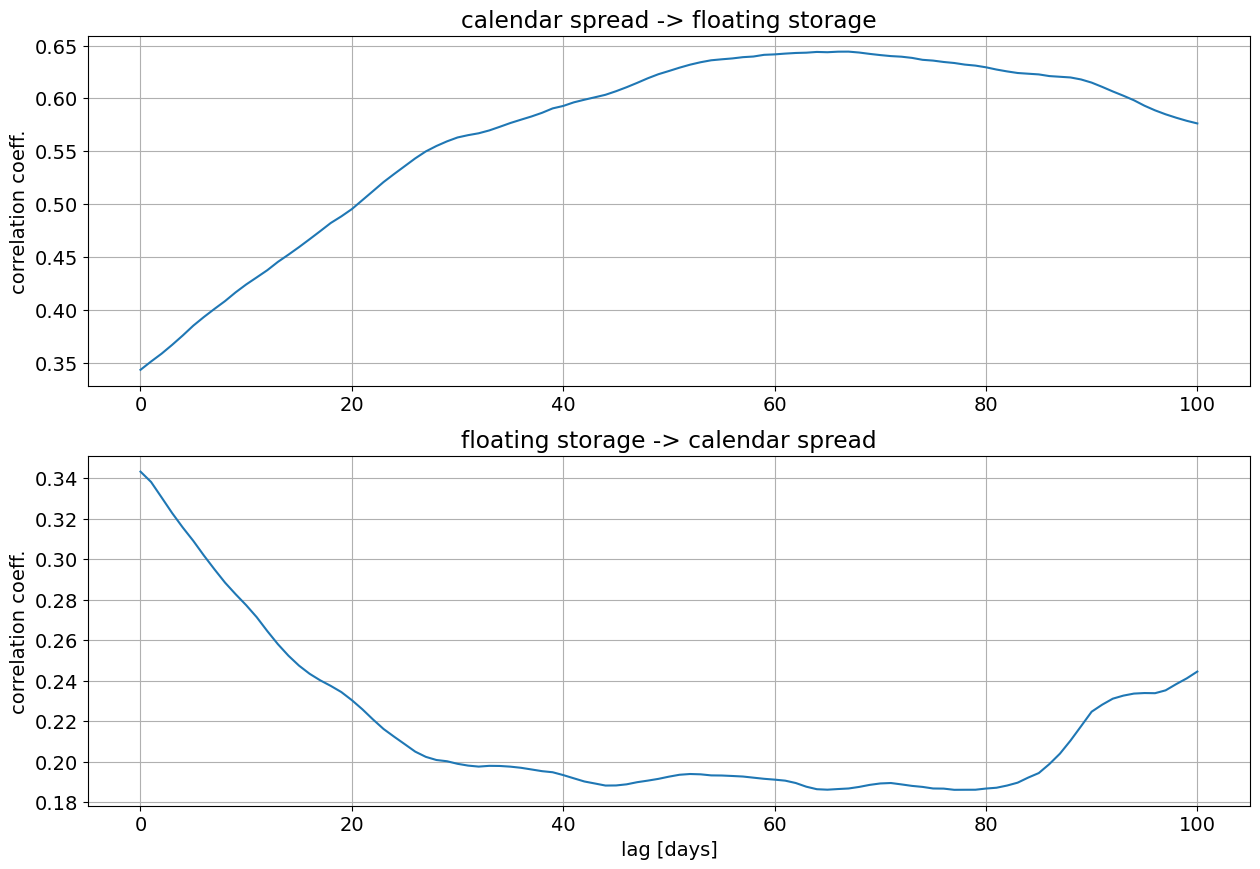

In [21]:
plot_crosscorr(calendar_spread, floating_storage, maxlag=MAXLAG, label_x='calendar spread', label_y='floating storage')

- By having two plots we will be able to analyse which direction the effect is strongest and which is the leading variable

- Plot 1 checks how well calendar spread leads floating storage at different lags. A high correlation at a positive lag would suggest that changes in calendar spread can predict future storage levels i.e. changes in calendar spread are followed by changes in floating storage with some delay. So, if calendar spread widens, floating storage should also follow suit and increase over time. Because the largest correlation coefficient value is after the largest lag, the effect of calendar spread on floating storage becomes more pronounced over time. 

- Plot 2 checks how well floating storage leads calendar spread at different lags. A lower correlation at a positive lag would suggest that changes in floating storage have less predictive power for future calendar spread. The declining correlation implies that an increase in floating storage today is not necessarily followed by a corresponding widening or narrowing of spread in the future. 

- Calendar spread and floating storage are positively correlated over the entire range of lag values examined. The largest value corresponds to the correlation between calendar spread and floating storage around 60 days into the future (top plot).

Next we cross correlate spot prices and floating storage

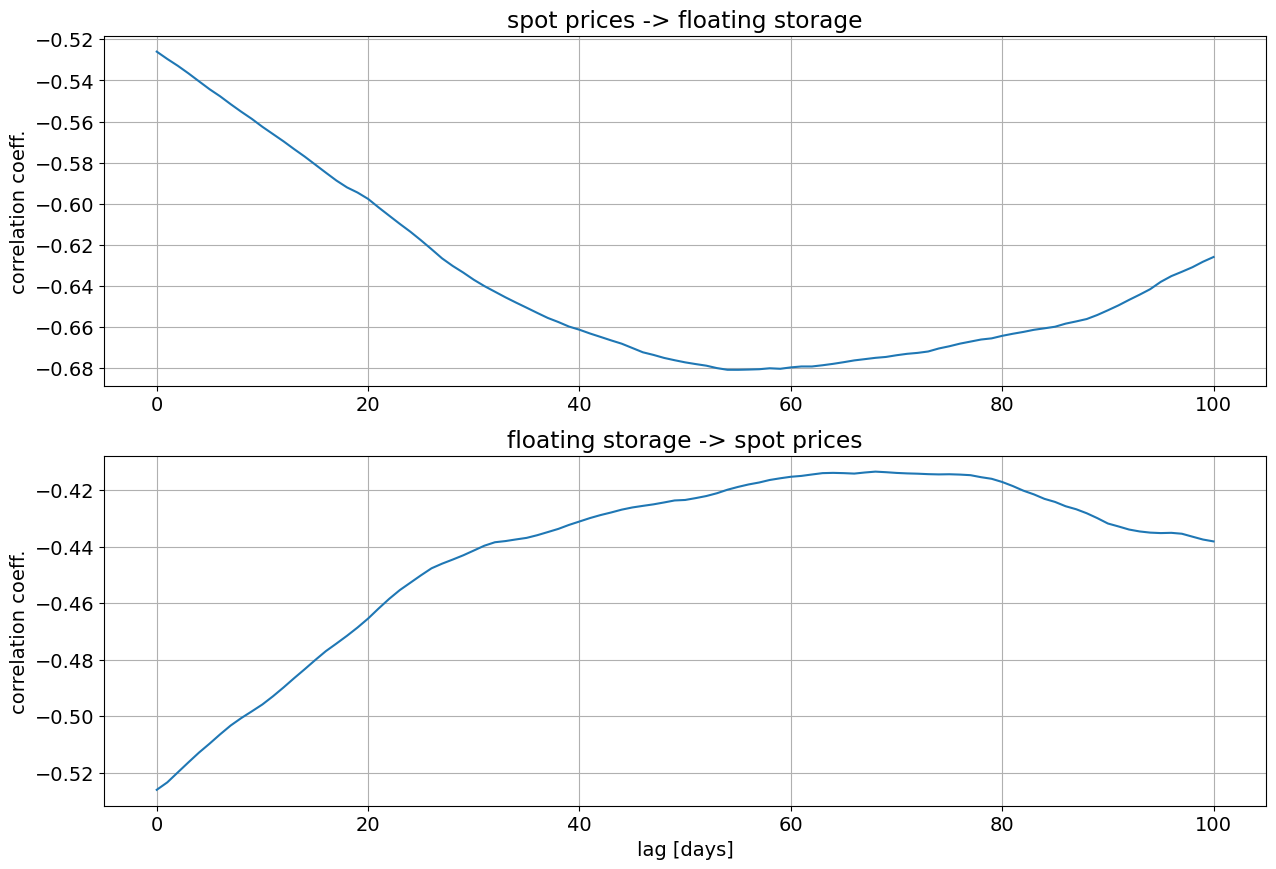

In [22]:
plot_crosscorr(spot_prices, floating_storage, maxlag=MAXLAG, label_x='spot prices', label_y='floating storage')

Spot prices are negatively correlated with floating storage over the entire range of lag values. The largest negative amplitude was found when spot prices were correlated with floating storage ~60 days in the future.

We use the crosscorr function to calculate and plot the autocorrelation of each time series (alternatively one can use pd.Series.autocorr iteratively).

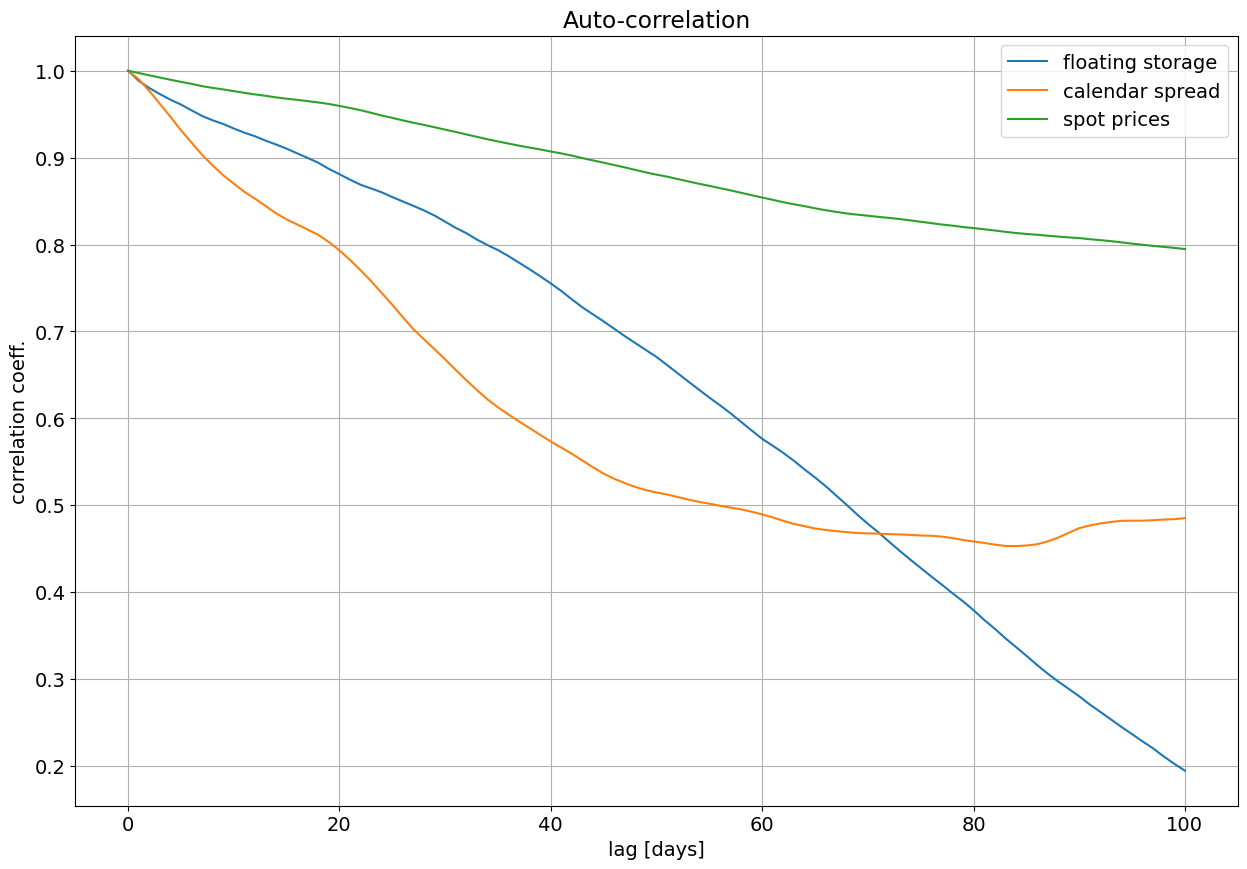

In [23]:
lags = np.arange(0, MAXLAG+1)

crosscorr(floating_storage, floating_storage, lags).plot()
crosscorr(calendar_spread, calendar_spread, lags).plot()
crosscorr(spot_prices, spot_prices, lags).plot()
plt.grid()
plt.title('Auto-correlation')
plt.legend(['floating storage', 'calendar spread', 'spot prices'])
plt.xlabel('lag [days]')
plt.ylabel('correlation coeff.');

The above graph shows the autocorrelation of spot prices, floating storage and calendar spread. 

- Spot prices stay correlated with themselves the longest, even at higher lags the autocorrelation remains high. This suggests that spot prices are more persistent over time. 

- Floating storage declines more rapidly compared to spot prices which can indicate that floating storage forgets its past levels more quickly. This might reflect the rapid adjustments owners of floating storage vessels made in response to prices during the covid period. 

- Calendar spread deteriorates the fastest out of the three but relative to floating storage, it makes a recovery after 2 months. 

## Granger Causality Analysis

In [24]:
gct = grangercausalitytests(pd.concat([floating_storage, calendar_spread], axis=1), maxlag=2, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6510  , p=0.0313  , df_denom=1091, df_num=1
ssr based chi2 test:   chi2=4.6638  , p=0.0308  , df=1
likelihood ratio test: chi2=4.6538  , p=0.0310  , df=1
parameter F test:         F=4.6510  , p=0.0313  , df_denom=1091, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3777  , p=0.0932  , df_denom=1088, df_num=2
ssr based chi2 test:   chi2=4.7772  , p=0.0918  , df=2
likelihood ratio test: chi2=4.7668  , p=0.0922  , df=2
parameter F test:         F=2.3777  , p=0.0932  , df_denom=1088, df_num=2


At lag = 1, p values are below 0.05, indicating statistical significance and imply that floating storage has some predictive power and can granger-cause calendar spread between 2020 and 2022. 

At lag = 2, the p values rise above 0.05 reflecting that the test is no longer significant. Hence, the predictive power of floating storage is significant at 1 lag but not 2. 

The COVID period saw heightened volatility and large fluctuations in floating storage, especially in 2020. The significance at a lag of 1 could reflect the turbulence of the period.  

In [25]:
def plot_granger_pvalues(series_x, series_y, maxlag, label_x, label_y, test='ssr_ftest', confidence_level=0.05):
    lags = np.arange(1, maxlag+1)

    plt.subplot(211)
    gct_x_y = grangercausalitytests(pd.concat([series_y, series_x], axis=1), maxlag=maxlag, verbose=False)
    pvalue_x_y = pd.Series([gct_x_y[lag][0][test][1] for lag in lags], index=lags)
    pvalue_x_y.plot(title=f'{label_x} -> {label_y}', grid=True)
    plt.plot((0, maxlag),(confidence_level, confidence_level),'--r')
    plt.ylabel('p-value')

    plt.subplot(212)
    gct_y_x = grangercausalitytests(pd.concat([series_x, series_y], axis=1), maxlag=maxlag, verbose=False)
    pvalue_y_x = pd.Series([gct_y_x[lag][0][test][1] for lag in lags], index=lags)
    pvalue_y_x.plot(title=f'{label_y} -> {label_x}', grid=True)
    plt.plot((0, maxlag),(confidence_level, confidence_level),'--r')
    plt.xlabel('lag [days]')
    plt.ylabel('p-value')


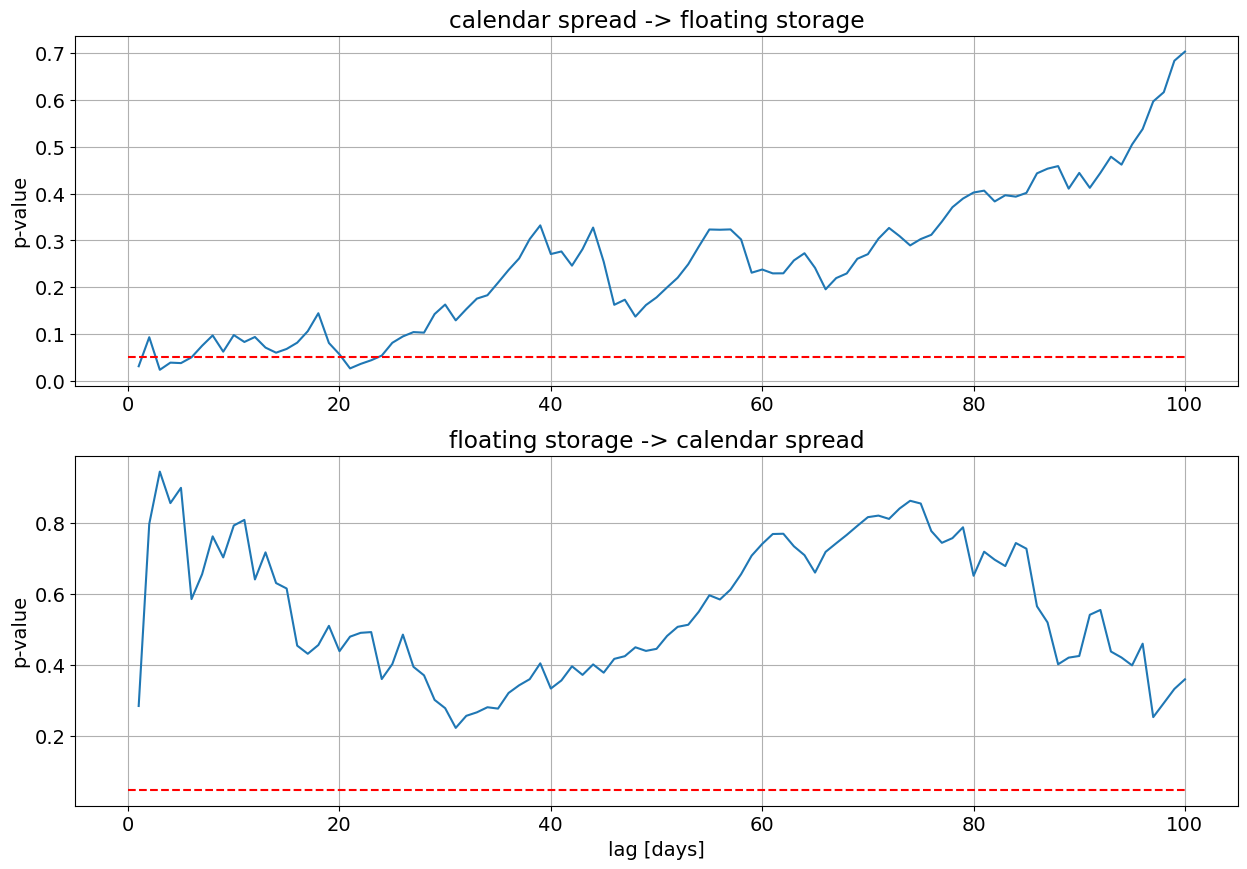

In [26]:
plot_granger_pvalues(calendar_spread, floating_storage, maxlag=MAXLAG, label_x='calendar spread', label_y='floating storage')

The blue lines indicate the p-values of the Granger causality tests, and to identify the significant results we need to look where the p-values dip below the threshold of significance (dashed red lines, set at the conventional threshold of 0.05), meaning that one variable causes the other at that specific lag.

- Top Plot
For very short periods there is some statistical significance, however, this effect quickly dissipates and any existence of it was short lived. This suggests that calendar spread does not have much predictive power, and does not granger-cause floating storage in the short term and especially not in the longer term. 

- Bottom Plot
Do past values of floating storage help to predict calendar spreads? According to our plot, no. Floating storage does not granger cause calendar spread across all lags between 0 and 100. 

In conclusion, whilst there is some short term granger causality from Calendar Spreads to Floating storage, the same cannot be said for the reverse direction. 

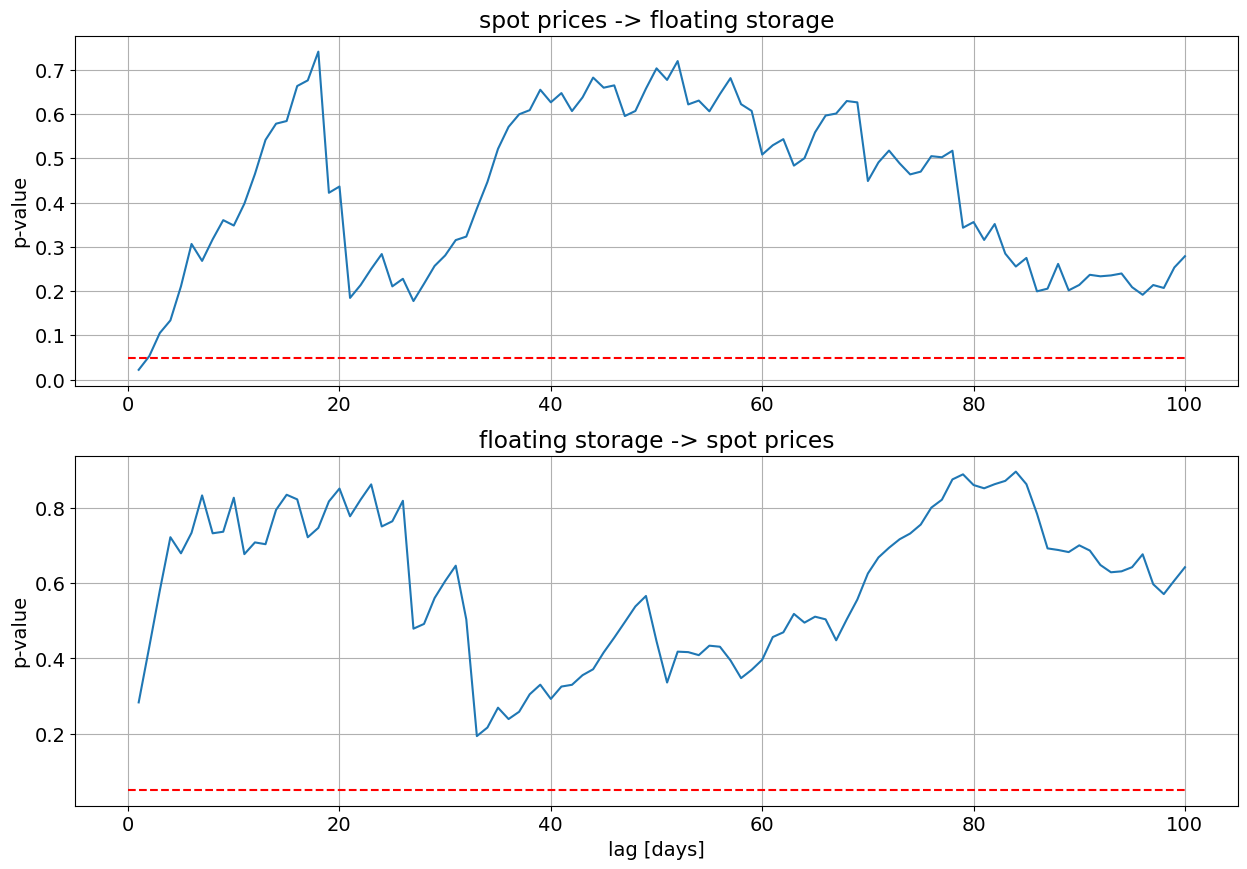

In [27]:
plot_granger_pvalues(spot_prices, floating_storage, maxlag=MAXLAG, label_x='spot prices', label_y='floating storage')

These plots show that spot prices do not granger-cause floating storage levels and past floating storage levels have no predictive power over spot prices. 
There is a small exception in the very short run which makes sense as traders and storage operators might react quickly to changes in spot prices. Beyond this extremely short period, the relationship disappears suggesting that other fundamental factors drive storage levels.

During this time period price volatility was extremely high and we saw a collapse in the demand for oil with extremely high storage build ups. It's possible that floating storage decisions were responding to other factors in the market. Operators of floating storage were likely basing decisions upon their perception of current affairs (economic lockdowns, OPEC cuts) and expectations of the future. 

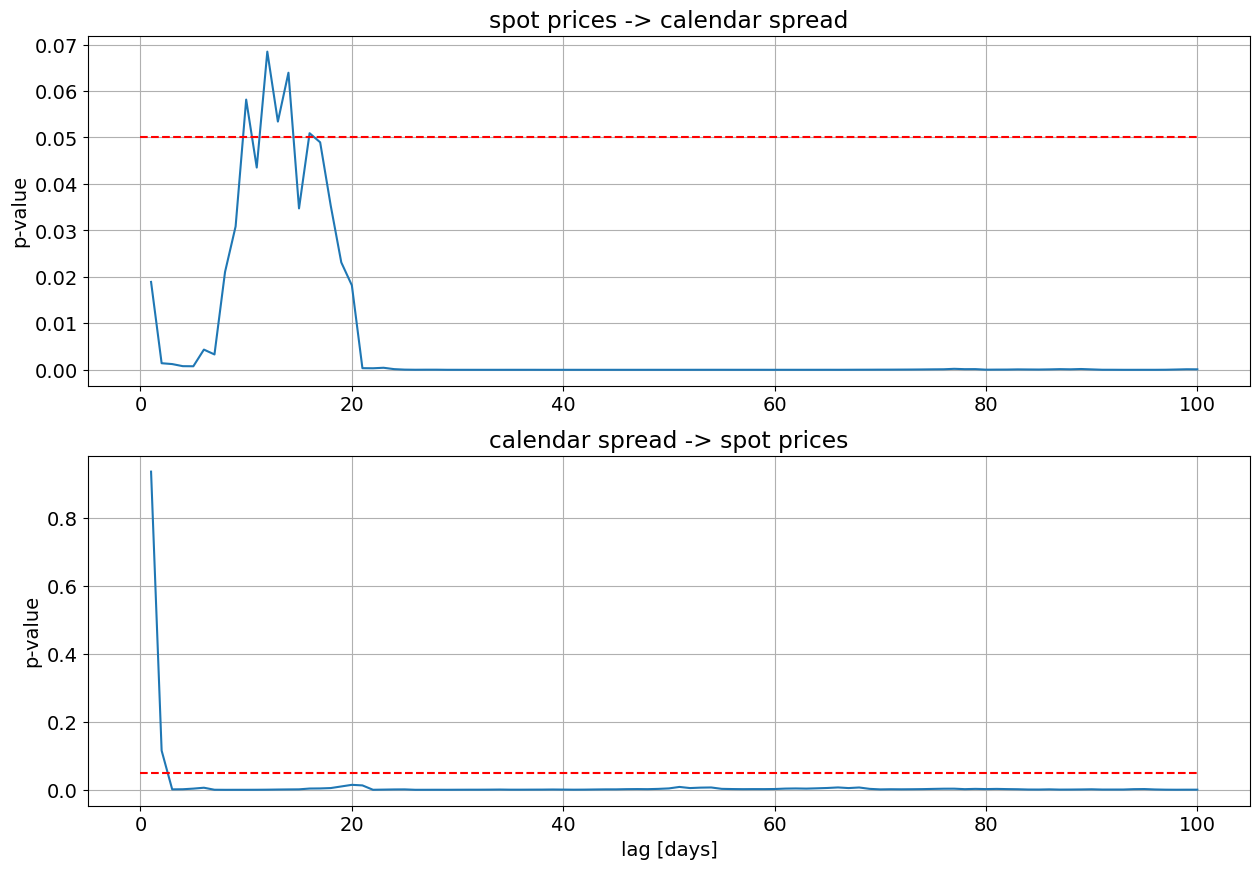

In [28]:
plot_granger_pvalues(spot_prices, calendar_spread, maxlag=MAXLAG, label_x='spot prices', label_y='calendar spread')

- Top Plot

Over very short lags (0–5 days), p-values are below 0.05, meaning that spot prices have significant predictive power over the calendar spread in the immediate short-term.
Between 5–18 days, p-values fluctuate around the 0.05 threshold, indicating that spot prices may still weakly influence the calendar spread, but the relationship is not as strong.
After lag ~20, p-values drop and remain at nearly 0.00, suggesting that spot prices have a persistent long-term predictive effect on calendar spreads.
We can say that spot prices significantly Granger-cause calendar spreads in the very short term and longer term (20+ days). This suggests that futures prices are adjusted based on spot price movements. 

- Bottom Plot 

Do past values of calendar spread help to predict spot prices? 
The p-values are extremely low for almost all lags indicating that there's a very strong statistical significance and calendar spreads Granger cause spot prices. 
This makes sense as the futures curve can act as a demand signal pushing up/down the spot price

This is interesting - futures prices influence the spot market and the spot market influences futures. This signals a reflexive relationship between the futures and spot market